In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m 
import collections
import pandas as pd
import sys 

def readin_csv_data(path):
    df = pd.read_csv(path) 
    X = df.iloc[:,:-1].values 
    Y = df.iloc[:,-1].values 
    return X, Y


def train_test_split_po(X, Y, train_size, shuffle):
    ''' Perform tran/test datasets splitting '''
    if shuffle:
        randomize = np.arange(len(X))
        np.random.shuffle(randomize)
        X = X[randomize]
        Y = Y[randomize]
    s_id = int(len(Y) * train_size)
    X_train, X_test = X[:s_id], X[s_id:]
    Y_train, Y_test = Y[:s_id], Y[s_id:]
    Y_train = Y_train.reshape((-1, 1))
    X_train1 = np.append(X_train, Y_train, axis = 1) 
    X_train1 = X_train1[np.argsort(X_train1[:, 0])]
    Y_test = Y_test.reshape((-1, 1))
    X_test1 = np.append(X_test, Y_test, axis = 1) 
    X_test1 = X_test1[np.argsort(X_test1[:, 0])]
    X_train, X_test = X_train1[:,:-1], X_test1[:,:-1]
    Y_train, Y_test = X_train1[:,-1], X_test1[:,-1]
    Y_train=np.squeeze(Y_train)
    Y_test=np.squeeze(Y_test)
    return X_train, X_test, Y_train, Y_test

def metric_accuracy(Y_label, Y_pred):
    '''Evaluate the accuracy'''
    correct_amount = 0 
    for i in range(np.size(Y_pred)) :   #np.size: Number of elements in the array
        if Y_label[i] == Y_pred[i] :             
            correct_amount = correct_amount + 1
    return correct_amount / np.size(Y_pred) * 100



class ClassificationDecisionTree():
    '''Decision Tree for Classification'''
    
    def __init__(self, max_depth, min_samples):
        self.md = max_depth
        self.ms = min_samples
        self.depth_init = 1
       
    def evaluate_gini_index(self, left, right, classes):
        gini = 0
        size_l = np.size(left, 0)
        size_r = np.size(right, 0)
        size_t = size_l +  size_r # Total sample No.
        spaces = [left, right]
        for space in spaces:
            size = np.size(space, 0) # Sample No. in different group
            if size == 0:   # Avoid 0 in denominator
                continue     
            tmp = 0.
            statis = collections.Counter(space[:,-1])
            for class_i in classes:
                p_k = statis[class_i] / size # +/- instances prob. in different group
                tmp += p_k*p_k
            gini += (1.0 - tmp) * (size / size_t)
        return gini    
    
    def node(self, X):
        '''split with the optimal gini index'''
        classes = collections.Counter(X[:,-1])
        classes = list(classes.keys())
        tmp_gini = 1
        for column in range(np.size(X, 1)-1):
            for row in X:
                left = np.empty((0, np.size(X, 1)))
                right = np.empty((0, np.size(X, 1)))
                for row2 in X:
                    if row2[column] < row[column]:
                        left = np.append(left, row2.reshape(-1,np.size(X, 1)), axis=0)
                    else:
                        right = np.append(right, row2.reshape(-1,np.size(X, 1)), axis=0)
                gini = self.evaluate_gini_index(left, right, classes)
                if gini < tmp_gini:
                        node_c, node_value, tmp_gini = column, row[column], gini
                        left_branch, right_branch = left, right
        #print('Node column: %f' % node_c ) 
        #print('Node value: %f' % node_value )
        #print('Node gini index: %f' % tmp_gini )
        #print('Left branch: ', left_branch )
        #print('Right branch: ', right_branch )
        return {'feature_id': node_c, 'node_value': node_value, \
            'Left_branch': left_branch, 'Right_branch': right_branch}

    def tree_grows(self, X, max_depth, min_samples, depth):
        '''Recursively growing binary tree'''
        left, right = X['Left_branch'], X['Right_branch']
        for key in ['Left_branch', 'Right_branch']:
            try:
                del X[key]
            except KeyError:
                pass
        if np.size(left, 0)==0 or np.size(right, 0)==0: # No need to split if encounter empty branch
            X['Left_branch'] = self.leaf_node(np.vstack((left,right)))
            X['Right_branch'] = self.leaf_node(np.vstack((left,right)))
            return
        if depth >= max_depth:   # tree depth should be smaller then max_depth
            X['Left_branch'] = self.leaf_node(left)
            X['Right_branch'] = self.leaf_node(right)
            return
        dict_tmp={'Left_branch':left, 'Right_branch':right}
        for i in ['Left_branch', 'Right_branch']:   # Left/Right branches grow
            if np.size(dict_tmp[i], 0) > min_samples: 
                X[i] = self.node(dict_tmp[i])
                self.tree_grows(X[i], self.md, self.ms, depth+1)
            else:
                X[i] = self.leaf_node(dict_tmp[i])
                
    def leaf_node(self, X):  
        '''node is viewed as leaf, the most voted label is the leaf node label'''
        statis = collections.Counter(X[:,-1])
        #print('The leaf node labels and counts: ', statis)
        max_votes=max(statis.values())
        lst=[i for i in statis.keys() if statis[i]==max_votes] 
        #print('The most voted leaf node label is: ', sorted(lst)[0]) 
        return sorted(lst)[0]        
    
    def fit(self, X):
        '''Used to obtain root node and build decision tree'''
        Node = self.node(X) # generate node
        self.tree_grows(Node, self.md, self.ms, self.depth_init)
        return Node
       
    def predict(self, X, Y):
        '''Used to predict test data Y based on tree X'''
        y_pred = np.zeros(np.size(Y, 0))
        for i in range(np.size(Y, 0)):
            if Y[i, int(X['feature_id'])] < X['node_value']:
                if isinstance(X['Left_branch'], dict):
                    return self.predict(X['Left_branch'], Y)
                else:
                    y_pred[i] = X['Left_branch']
            else:
                if isinstance(X['Right_branch'], dict):
                    return self.predict(X['Right_branch'], Y)
                else:
                    y_pred[i] = X['Right_branch']
        return y_pred.astype(int)    
    
    def export_tree(self, X, depth=0):
        if isinstance(X, dict):
            print(('%s%sfeature_%d <= %f')% (depth*'| ', '|--', X['feature_id'], X['node_value']))
            self.export_tree(X['Left_branch'], depth+1)
            #print(('%s%sfeature_%d > %f')% (depth*'| ', '|--', X['feature_id'], X['node_value']))
            self.export_tree(X['Right_branch'], depth+1)
        else:
            print(('%s%sclass: %f')%(depth*'| ', '|--', X))
            
            
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            print('%s[X%d < %.3f]' % ((depth*' ', (node['feature_id']+1), node['node_value'])))
            self.print_tree(node['Left_branch'], depth+1)
            self.print_tree(node['Right_branch'], depth+1)
        else:
            print('%s[%s]' % ((depth*' ', node)))

In [58]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install python-graphviz

In [2]:
from graphviz import Digraph


def visualize_tree_root_node(g, X):
    g.node(name = 'F_%d <= %.2f'%(X['feature_id'],X['node_value']), \
           shape='box', color='black',style='filled',fillcolor='lemonchiffon')

def visualize_tree(g, X):
       
    if not isinstance(X['Left_branch'], dict) and not isinstance(X['Right_branch'], dict):  
        #if X['Left_branch']!=X['Right_branch']:
            #g.node('%.2f'%(X['node_value']))
        g.node(name='%.2f left child'%(X['node_value']), label='%.2f'%(X['Left_branch']),\
               shape='diamond', color='black',style='filled',fillcolor='darkorange1')
        g.node(name='%.2f right child'%(X['node_value']), label='%.2f'%(X['Right_branch']),\
               shape='diamond', color='black',style='filled',fillcolor='darkorange1')
        g.edge('F_%d <= %.2f'%(X['feature_id'],X['node_value']), '%.2f left child'%(X['node_value']), label='True')
        g.edge('F_%d <= %.2f'%(X['feature_id'],X['node_value']), '%.2f right child'%(X['node_value']), label='False')
        #else:
            #g.node('%.2f'%(X['node_value']))
            #g.node(name='%.2f child'%(X['node_value']), label='%.2f'%(X['Left_branch']))
            #g.edge('F_%d <= %.2f'%(X['feature_id'],X['node_value']), '%.2f'%(X['Left_branch']))

    elif isinstance(X['Left_branch'], dict) and not isinstance(X['Right_branch'], dict): 
        #g.node('%.2f'%(X['node_value']))
        #g.node(name='%.2f left child'%(X['node_value']), label='%.2f'%(X['Left_branch']['node_value']))
        #g.edge('%.2f'%(X['node_value']), '%.2f left child'%(X['node_value']), label='true')
        g.edge('F_%d <= %.2f'%(X['feature_id'],X['node_value']), 'F_%d <= %.2f'%(X['Left_branch']['feature_id'],X['Left_branch']['node_value']),\
               label='True')
        g.node(name='%.2f right child'%(X['node_value']), label='%.2f'%(X['Right_branch']), \
               shape='diamond', color='black',style='filled',fillcolor='darkorange1')
        g.edge('F_%d <= %.2f'%(X['feature_id'],X['node_value']), '%.2f right child'%(X['node_value']), label='False')
        visualize_tree(g, X['Left_branch'])
    elif not isinstance(X['Left_branch'], dict) and isinstance(X['Right_branch'], dict):
        #g.node('%.2f'%(X['node_value']))
        g.node(name='%.2f left child'%(X['node_value']), label='%.2f'%(X['Left_branch']),\
               shape='diamond', color='black',style='filled',fillcolor='darkorange1')
        #g.node(name='%.2f right child'%(X['node_value']), label='%.2f'%(X['Right_branch']['node_value']))
        g.edge('F_%d <= %.2f'%(X['feature_id'],X['node_value']), '%.2f left child'%(X['node_value']), label='True')
        #g.edge('%.2f'%(X['node_value']), '%.2f right child'%(X['node_value']), label='false')
        g.edge('F_%d <= %.2f'%(X['feature_id'],X['node_value']), 'F_%d <= %.2f'%(X['Right_branch']['feature_id'],X['Right_branch']['node_value']), \
               label='False')
        visualize_tree(g, X['Right_branch'])
    else:
        #g.node('%.2f'%(X['node_value']))
        #g.node(name='%.2f left child'%(X['node_value']), label='%.2f'%(X['Left_branch']['node_value']))
        #g.node(name='%.2f right child'%(X['node_value']), label='%.2f'%(X['Right_branch']['node_value']))
        g.edge('F_%d <= %.2f'%(X['feature_id'],X['node_value']),\
               'F_%d <= %.2f'%(X['Left_branch']['feature_id'],X['Left_branch']['node_value']), label='True')
        g.edge('F_%d <= %.2f'%(X['feature_id'],X['node_value']), \
               'F_%d <= %.2f'%(X['Right_branch']['feature_id'],X['Right_branch']['node_value']), label='False')
        visualize_tree(g, X['Left_branch'])
        visualize_tree(g, X['Right_branch'])
        
        

In [3]:
def main():
    truncate_train=300
    truncate_test=50
    X, Y = readin_csv_data('data_banknote_authentication.csv')
    X_train, X_test, Y_train, Y_test = train_test_split_po(X, Y, train_size=.8, shuffle=True)
    X_trainset = np.hstack((X_train[:truncate_train, :], Y_train.reshape(-1,1)[:truncate_train, :]))
    X_testset = np.hstack((X_test[:truncate_test, :], Y_test.reshape(-1,1)[:truncate_test, :]))
    #X_trainset = np.hstack((X_train[:, :], Y_train.reshape(-1,1)[:, :]))
    #X_testset = np.hstack((X_test[:, :], Y_test.reshape(-1,1)[:, :]))
    model =  ClassificationDecisionTree(max_depth = 3, min_samples = 10)   
    tree = model.fit(X_trainset)
    print(tree)
    model.export_tree(tree)
    y_pred = model.predict(tree, X_testset)
    y_label = X_testset[:, -1].astype(int)
    print('Accuracy: ', metric_accuracy(y_label, y_pred), ' %') 
    g = Digraph('G', filename='DT.gv', format='png')
    #g = Digraph()
    visualize_tree_root_node(g, X1)
    visualize_tree(g, X1)
    g.view()

if __name__ == '__main__':  
    main()

{'feature_id': 1, 'node_value': 10.1374, 'Left_branch': {'feature_id': 1, 'node_value': 7.886, 'Left_branch': {'feature_id': 0, 'node_value': -1.6952, 'Left_branch': 1.0, 'Right_branch': 1.0}, 'Right_branch': {'feature_id': 0, 'node_value': -4.2859, 'Left_branch': 1.0, 'Right_branch': 0.0}}, 'Right_branch': {'feature_id': 0, 'node_value': -2.7419, 'Left_branch': 0.0, 'Right_branch': 0.0}}
|--feature_1 <= 10.137400
| |--feature_1 <= 7.886000
| | |--feature_0 <= -1.695200
| | | |--class: 1.000000
| | | |--class: 1.000000
| | |--feature_0 <= -4.285900
| | | |--class: 1.000000
| | | |--class: 0.000000
| |--feature_0 <= -2.741900
| | |--class: 0.000000
| | |--class: 0.000000
Accuracy:  92.0  %


digraph G {
	"F_1 <= 10.14" [color=black fillcolor=lemonchiffon shape=box style=filled]
	"F_1 <= 10.14" -> "F_1 <= 7.89" [label=True]
	"F_1 <= 10.14" -> "F_0 <= -2.74" [label=False]
	"F_1 <= 7.89" -> "F_0 <= -1.70" [label=True]
	"F_1 <= 7.89" -> "F_0 <= -4.29" [label=False]
	"-1.70 left child" [label=1.00 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"-1.70 right child" [label=1.00 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"F_0 <= -1.70" -> "-1.70 left child" [label=True]
	"F_0 <= -1.70" -> "-1.70 right child" [label=False]
	"-4.29 left child" [label=1.00 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"-4.29 right child" [label=0.00 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"F_0 <= -4.29" -> "-4.29 left child" [label=True]
	"F_0 <= -4.29" -> "-4.29 right child" [label=False]
	"-2.74 left child" [label=0.00 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"-2.74 right child" [label=0.00 color=black 

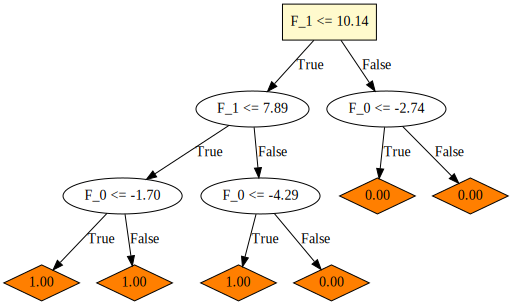

In [12]:
X1={'feature_id': 1, 'node_value': 10.1374, 'Left_branch': \
    {'feature_id': 1, 'node_value': 7.886, 'Left_branch': \
    {'feature_id': 0, 'node_value': -1.6952, 'Left_branch': 1.0,\
    'Right_branch': 1.0}, 'Right_branch': {'feature_id': 0, 'node_value': -4.2859,\
    'Left_branch': 1.0, 'Right_branch': 0.0}}, 'Right_branch': {'feature_id': 0, \
    'node_value': -2.7419, 'Left_branch': 0.0, 'Right_branch': 0.0}}
g = Digraph('G', filename='DT.gv', format='png')
visualize_tree_root_node(g, X1)
visualize_tree(g, X1)
g.view()
print(g.source) 
g

# Update code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m 
import collections
import pandas as pd
import sys 

def readin_csv_data(path):
    df = pd.read_csv(path) 
    X = df.iloc[:,:-1].values 
    Y = df.iloc[:,-1].values 
    return X, Y


def train_test_split_po(X, Y, train_size, shuffle):
    ''' Perform tran/test datasets splitting '''
    if shuffle:
        randomize = np.arange(len(X))
        np.random.shuffle(randomize)
        X = X[randomize]
        Y = Y[randomize]
    s_id = int(len(Y) * train_size)
    X_train, X_test = X[:s_id], X[s_id:]
    Y_train, Y_test = Y[:s_id], Y[s_id:]
    Y_train = Y_train.reshape((-1, 1))
    X_train1 = np.append(X_train, Y_train, axis = 1) 
    X_train1 = X_train1[np.argsort(X_train1[:, 0])]
    Y_test = Y_test.reshape((-1, 1))
    X_test1 = np.append(X_test, Y_test, axis = 1) 
    X_test1 = X_test1[np.argsort(X_test1[:, 0])]
    X_train, X_test = X_train1[:,:-1], X_test1[:,:-1]
    Y_train, Y_test = X_train1[:,-1], X_test1[:,-1]
    Y_train=np.squeeze(Y_train)
    Y_test=np.squeeze(Y_test)
    return X_train, X_test, Y_train, Y_test

def metric_accuracy(Y_label, Y_pred):
    '''Evaluate the accuracy'''
    correct_amount = 0 
    for i in range(np.size(Y_pred)) :   #np.size: Number of elements in the array
        if Y_label[i] == Y_pred[i] :             
            correct_amount = correct_amount + 1
    return correct_amount / np.size(Y_pred) * 100



class DecisionTree():
    '''Classification And Regression Tree 
    ------------------------------------
    Input data structure: numpy array with m x (d+1) shape, 
                          m rows of samples included, 
                          d columns of features/ttributes,
                          and 1 column of target'''
    
    
    def __init__(self, max_depth, min_samples, criterion):
        self.md = max_depth
        self.ms = min_samples
        self.depth_init = 1
        self.criterion = criterion
       
    def evaluate_gini_index(self, left, right, classes):
        '''Gini impurity for classification'''
        gini = 0
        size_l = left.shape[0]
        size_r = right.shape[0]
        size_t = size_l +  size_r # Total sample No.
        spaces = [left, right]
        for space in spaces:
            size = space.shape[0] # Sample No. in different group
            if size == 0:   # Avoid 0 in denominator
                continue     
            tmp = 0.
            statis = collections.Counter(space[:,-1])
            tmp=sum([(float(statis[class_i])/float(space.shape[0]))**2.0 for class_i in classes])
            gini += (1.0 - tmp) * (size / size_t)
        return gini    
    
    def evaluate_mse_index(self, left, right):
        '''MSE index for regression'''
        mse = 0
        spaces = [left, right]
        for space in spaces:
            mse += np.mean((space[:,-1] - np.mean(space[:,-1]))**2.)
        return mse    
    
    def node(self, X):
        '''split with the optimal gini/mse index'''
        classes = collections.Counter(X[:,-1])
        classes = list(classes.keys())
        tmp_value = 1000     # This is a random choice, may need more careful for regession case.
        #for column in range(np.size(X, 1)-1):
        for column in range(X.shape[1]-1):
            for row in X:
                #left = np.empty((0, np.size(X, 1)))
                #right = np.empty((0, np.size(X, 1)))
                left = np.empty((0, X.shape[1]))
                right = np.empty((0, X.shape[1]))
                for row2 in X:
                    if row2[column] < row[column]:
                        left = np.append(left, row2.reshape(-1,np.size(X, 1)), axis=0)
                    else:
                        right = np.append(right, row2.reshape(-1,np.size(X, 1)), axis=0)
                if (self.criterion == 'gini'):
                    gini = self.evaluate_gini_index(left, right, classes)
                    if gini < tmp_value:
                            node_c, node_value, tmp_value = column, row[column], gini
                            left_branch, right_branch = left, right
                elif (self.criterion == 'mse'):
                    mse = self.evaluate_mse_index(left, right)
                    if mse < tmp_value:
                            node_c, node_value, tmp_value = column, row[column], mse
                            left_branch, right_branch = left, right
                else:
                    print('I\'m trying to add more criterion in it! ')
        #print('Node column: %f' % node_c ) 
        #print('Node value: %f' % node_value )
        #print('Node gini index: %f' % tmp_gini )
        #print('Left branch: ', left_branch )
        #print('Right branch: ', right_branch )
        return {'feature_id': node_c, 'node_value': node_value, \
            'Left_branch': left_branch, 'Right_branch': right_branch}

    def tree_grows(self, X, max_depth, min_samples, depth):
        '''Recursively growing binary tree'''
        left, right = X['Left_branch'], X['Right_branch']
        for key in ['Left_branch', 'Right_branch']:
            try:
                del X[key]
            except KeyError:
                pass
        #if np.size(left, 0)==0 or np.size(right, 0)==0:
        if left.shape[0]==0 or right.shape[0]==0: # No need to split if encounter empty branch
            X['Left_branch'] = self.leaf_node(np.vstack((left,right)))
            X['Right_branch'] = self.leaf_node(np.vstack((left,right)))
            return
        if depth >= max_depth:   # tree depth should be smaller then max_depth
            X['Left_branch'] = self.leaf_node(left)
            X['Right_branch'] = self.leaf_node(right)
            return
        dict_tmp={'Left_branch':left, 'Right_branch':right}
        for i in ['Left_branch', 'Right_branch']:   # Left/Right branches grow
            #if np.size(dict_tmp[i], 0) > min_samples: 
            if dict_tmp[i].shape[0] > min_samples: 
                X[i] = self.node(dict_tmp[i])
                self.tree_grows(X[i], self.md, self.ms, depth+1)
            else:
                X[i] = self.leaf_node(dict_tmp[i])
                
    def leaf_node(self, X):  
        '''node is viewed as leaf, the most voted label is the leaf node label'''
        if (self.criterion == 'gini'):
            statis = collections.Counter(X[:,-1])
            #print('The leaf node labels and counts: ', statis)
            max_votes=max(statis.values())
            lst=[i for i in statis.keys() if statis[i]==max_votes] 
            #print('The most voted leaf node label is: ', sorted(lst)[0]) 
            return sorted(lst)[0]    
        elif (self.criterion == 'mse'): 
            return np.mean(X[:,-1])  
            
    
    def fit(self, X):
        '''Used to obtain root node and build decision tree'''
        start1 = time.time()
        Node = self.node(X) # generate node
        end1 = time.time()
        print(f"Runtime of the node is {end1 - start1}")
        self.tree_grows(Node, self.md, self.ms, self.depth_init)
        return Node
    
    def predict_sample(self, X, Y):
        '''Used to predict each sample data Y based on tree X'''
        if Y[int(X['feature_id'])] < X['node_value']:
            if isinstance(X['Left_branch'], dict):
                return self.predict_sample(X['Left_branch'], Y)
            else:
                y_pred = X['Left_branch']
        else:
            if isinstance(X['Right_branch'], dict):
                return self.predict_sample(X['Right_branch'], Y)
            else:
                y_pred = X['Right_branch']
        return y_pred     
    
    def make_prediction(self, X, Y):
        '''make prediction for given test data Y
           based on tree X'''
        Y_pred = np.empty((0,1))
        for i in range(Y.shape[0]):
            tmp = self.predict_sample(X, Y[i])
            tmp1 = np.array(tmp)
            tmp1 = tmp1.reshape(-1,1)
            Y_pred = np.append(Y_pred, tmp1, axis=0)
        Y_pred = np.squeeze(Y_pred)
        return Y_pred
    
        
    
    
    def export_tree(self, X, depth=0):
        if isinstance(X, dict):
            print(('%s%sfeature_%d <= %f')% (depth*'| ', '|--', X['feature_id'], X['node_value']))
            self.export_tree(X['Left_branch'], depth+1)
            print(('%s%sfeature_%d > %f')% (depth*'| ', '|--', X['feature_id'], X['node_value']))
            self.export_tree(X['Right_branch'], depth+1)
        else:
            if self.criterion == 'gini':
                print(('%s%sclass: %f')%(depth*'| ', '|--', X))
            elif self.criterion == 'mse':
                print(('%s%savg value: %f')%(depth*'| ', '|--', X))
            
            
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            print('%s[X%d < %.3f]' % ((depth*' ', (node['feature_id']+1), node['node_value'])))
            self.print_tree(node['Left_branch'], depth+1)
            self.print_tree(node['Right_branch'], depth+1)
        else:
            print('%s[%s]' % ((depth*' ', node)))

Runtime of the node is 1.1484360694885254
{'feature_id': 1, 'node_value': 10.1374, 'Left_branch': {'feature_id': 0, 'node_value': -2.7914, 'Left_branch': {'feature_id': 1, 'node_value': 8.5234, 'Left_branch': 1.0, 'Right_branch': 1.0}, 'Right_branch': 1.0}, 'Right_branch': 0.0}
|--feature_1 <= 10.137400
| |--feature_0 <= -2.791400
| | |--feature_1 <= 8.523400
| | | |--class: 1.000000
| | |--feature_1 > 8.523400
| | | |--class: 1.000000
| |--feature_0 > -2.791400
| | |--class: 1.000000
|--feature_1 > 10.137400
| |--class: 0.000000
Accuracy:  100.0  %


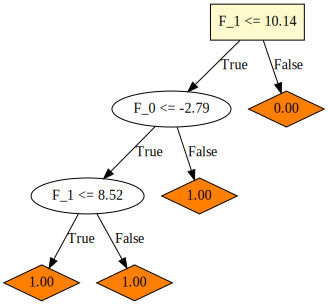

In [3]:
import time

truncate_train=100
truncate_test=50
X, Y = readin_csv_data('data_banknote_authentication.csv')
X_train, X_test, Y_train, Y_test = train_test_split_po(X, Y, train_size=.8, shuffle=False)
X_trainset = np.hstack((X_train[:truncate_train, :], Y_train.reshape(-1,1)[:truncate_train, :]))
X_testset = np.hstack((X_test[:truncate_test, :], Y_test.reshape(-1,1)[:truncate_test, :]))
    #X_trainset = np.hstack((X_train[:, :], Y_train.reshape(-1,1)[:, :]))
    #X_testset = np.hstack((X_test[:, :], Y_test.reshape(-1,1)[:, :]))
model =  DecisionTree(max_depth = 3, min_samples = 10, criterion='gini')   
tree = model.fit(X_trainset)
print(tree)
model.export_tree(tree)
y_pred = np.zeros(X_testset.shape[0])
y_pred = model.make_prediction(tree, X_testset)
y_label = X_testset[:, -1].astype(int)
print('Accuracy: ', metric_accuracy(y_label, y_pred.astype(int)), ' %') 
g = Digraph('G', filename='test.gv')
visualize_tree_root_node(g, tree)
visualize_tree(g, tree)
g

(80, 2)
Runtime of the node is 0.1874072551727295
{'feature_id': 0, 'node_value': 0.1674484673463209, 'Left_branch': 0.03414371136504074, 'Right_branch': {'feature_id': 0, 'node_value': 2.7315823199283353, 'Left_branch': {'feature_id': 0, 'node_value': 0.5317628874000062, 'Left_branch': 0.2998817726951682, 'Right_branch': 0.8581469719230311}, 'Right_branch': {'feature_id': 0, 'node_value': 2.859954163475055, 'Left_branch': 0.37954524418163094, 'Right_branch': 0.2285327645462946}}}
|--feature_0 <= 0.167448
| |--avg value: 0.034144
|--feature_0 > 0.167448
| |--feature_0 <= 2.731582
| | |--feature_0 <= 0.531763
| | | |--avg value: 0.299882
| | |--feature_0 > 0.531763
| | | |--avg value: 0.858147
| |--feature_0 > 2.731582
| | |--feature_0 <= 2.859954
| | | |--avg value: 0.379545
| | |--feature_0 > 2.859954
| | | |--avg value: 0.228533


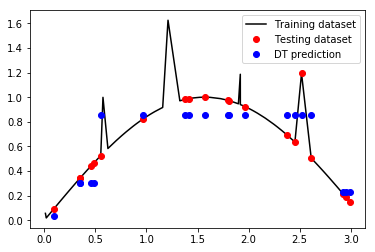

In [34]:
import time
X = np.sort(3*np.random.random_sample((100, 1)), axis = 0)
Y = np.sin(X).ravel()
Y[::20] += .7*np.random.random_sample(5)
plt.plot(X, Y, 'k', label='Training dataset')
X_train, X_test, Y_train, Y_test = train_test_split_po(X, Y, train_size=.8, shuffle=True)
X_trainset = np.hstack((X_train[:, :], Y_train.reshape(-1,1)[:, :]))
X_testset = np.hstack((X_test[:, :], Y_test.reshape(-1,1)[:, :]))
print(X_trainset.shape)
model =  DecisionTree(max_depth =3, min_samples = 3, criterion='mse')   
tree = model.fit(X_trainset)
print(tree)
model.export_tree(tree)




Y_pred=model.make_prediction(tree, X_testset)

y_label = X_testset[:, -1]
plt.plot(X_testset[:,:-1], y_label, 'ro', label='Testing dataset')
plt.plot(X_testset[:,:-1], Y_pred, 'bo', label='DT prediction')
plt.legend()


digraph G {
	"F_0 <= 0.17" [color=black fillcolor=lemonchiffon shape=box style=filled]
	"0.17 left child" [label=0.03 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"F_0 <= 0.17" -> "0.17 left child" [label=True]
	"F_0 <= 0.17" -> "F_0 <= 2.73" [label=False]
	"F_0 <= 2.73" -> "F_0 <= 0.53" [label=True]
	"F_0 <= 2.73" -> "F_0 <= 2.86" [label=False]
	"0.53 left child" [label=0.30 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"0.53 right child" [label=0.86 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"F_0 <= 0.53" -> "0.53 left child" [label=True]
	"F_0 <= 0.53" -> "0.53 right child" [label=False]
	"2.86 left child" [label=0.38 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"2.86 right child" [label=0.23 color=black fillcolor=darkorange1 shape=diamond style=filled]
	"F_0 <= 2.86" -> "2.86 left child" [label=True]
	"F_0 <= 2.86" -> "2.86 right child" [label=False]
}


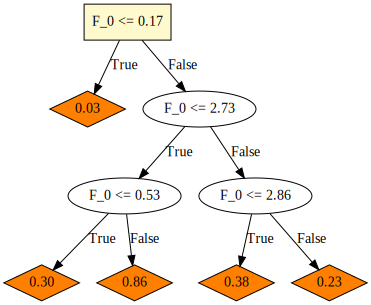

In [37]:
tree = {'feature_id': 0, 'node_value': 0.1674484673463209, 'Left_branch': 0.03414371136504074, 'Right_branch': {'feature_id': 0, 'node_value': 2.7315823199283353, 'Left_branch': {'feature_id': 0, 'node_value': 0.5317628874000062, 'Left_branch': 0.2998817726951682, 'Right_branch': 0.8581469719230311}, 'Right_branch': {'feature_id': 0, 'node_value': 2.859954163475055, 'Left_branch': 0.37954524418163094, 'Right_branch': 0.2285327645462946}}}
g = Digraph('G', filename='DT.gv', format='png')
visualize_tree_root_node(g, tree)
visualize_tree(g, tree)
g.view()
print(g.source) 
g